In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import torch #Deep learning
from torch import nn
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os

In [2]:
#needed this code to get working on my local machine. May not be necessary
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def crop_img(img, new_shape):
    """
    Crops img into new tensor of size new_shape
    """
    if (new_shape[-1] % 2 == 0):
        l_w = int((img.shape[-1] - new_shape[-1]) / 2)
        u_w = int((img.shape[-1] + new_shape[-1]) / 2)
        l_h = int((img.shape[-2] - new_shape[-2]) / 2)
        u_h = int((img.shape[-2] + new_shape[-2]) / 2)
    else:
        l_w = int((img.shape[-1] - new_shape[-1]) / 2) + 1
        u_w = int((img.shape[-1] + new_shape[-1]) / 2) + 1
        l_h = int((img.shape[-2] - new_shape[-2]) / 2) + 1
        u_h = int((img.shape[-2] + new_shape[-2]) / 2) + 1
    cropped_image = img[:, :, l_h:u_h, l_w:u_w]
    return cropped_image

In [4]:
def show_tensor_images(image_tensor, size=(3, 256, 256), num_images=8):
    """
    Displays tensors as images
    Function created by deeplearning.ai as part of GAN course
    """
    image_flattened = image_tensor.detach().cpu().view(-1, *size)
    grid = make_grid(image_flattened[:num_images], nrow=4)
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.show()

In [5]:
class ImageData(Dataset):
    def __init__(self, main_dir, transform):
        """
        Initialize image dataset
        :main_dir: the directory of image locations
        :transform: tensor transform to apply to images
        """
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = os.listdir(main_dir)

    def __len__(self):
        """
        :return: length of the dataset
        """
        return len(self.all_imgs)

    def __getitem__(self, idx):
        """
        Gets item[idx] from dataset as tensor
        """
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [6]:
#create trainloader
images = ImageData('train', transforms.ToTensor())
train_loader = DataLoader(images, batch_size=4, shuffle=True)

# Define torch model components

### Unet

In [7]:
class CompressingBlock(nn.Module):
    def __init__(self, input_channels, batch_norm = True, dropout = False):
        """
        Constructor function for Compression Block of Unet
        :input_channels: The number of input channels of x
        :batch_norm: Determines the use of batch normalization
        :dropout: Determines the use of dropout
        """
        super(CompressingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, (input_channels*2), kernel_size=3, padding = 1)
        self.conv2 = nn.Conv2d((input_channels*2), (input_channels*2), kernel_size=3, padding = 1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.use_batch_norm = batch_norm
        self.use_dropout = dropout
        if batch_norm:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        if dropout:
            self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward iteration of block
        :x: Tensor batch
        """
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
    
    

In [8]:
class ExpandingBlock(nn.Module):
    def __init__(self, input_channels, batch_norm = True, dropout = False, inject_noise = False):
        """
        Constructor function for Expanding Block of Unet
        :input_channels: The number of input channels of x
        :batch_norm: Determines the use of batch normalization
        :dropout: Determines the use of dropout
        :inject_noise: inject random noise into x if True
        """
        super(ExpandingBlock, self).__init__()
        
        self.upsample2x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, int(input_channels/2), kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(int(input_channels/2), int(input_channels/2), kernel_size=2, padding = 1)
        self.relu = nn.ReLU()
        self.use_batch_norm = batch_norm
        self.use_dropout = dropout
        self.use_noise = inject_noise
        if batch_norm:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        if dropout:
            self.dropout = nn.Dropout(0.3)
        
    def forward(self, x, res):
        """
        Forward iteration of block
        :x: Tensor batch
        """
        x = self.upsample2x(x)
        x = self.conv1(x)
        if self.use_noise:
            x = torch.add(x,(torch.randn(x.shape, device=x.device) * 0.05))
        res = crop_img(res, x.shape)
        x = torch.cat([x, res], axis=1)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.relu(x)
        return x

In [9]:
class FeatureMap(nn.Module):
    def __init__(self, input_channels, output_channels):
        """
        Simple 2d convoltional filter.
        Maps image to features
        """
        super(FeatureMap, self).__init__()
        
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
    
    def forward(self, x):
        
        x = self.conv(x)
        return x
        

In [10]:
class Unet(nn.Module):
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        """
        Contructor for Unet generator
        :input_channels: The input channels of initial tensor
        :output_channels: The output channels of desired tensor
        :hidden_channels: How many features to map initial tensor to
        """
        super(Unet, self).__init__()
        
        self.imToFeatures = FeatureMap(input_channels, hidden_channels)
        self.compress1 = CompressingBlock(hidden_channels, dropout=True)
        self.compress2 = CompressingBlock(hidden_channels * 2, dropout=True)
        self.compress3 = CompressingBlock(hidden_channels * 4)
        self.compress4 = CompressingBlock(hidden_channels * 8)
        self.compress5 = CompressingBlock(hidden_channels * 16)
        self.compress6 = CompressingBlock(hidden_channels * 32)
        self.compress7 = CompressingBlock(hidden_channels * 64)
        self.expand0 = ExpandingBlock(hidden_channels * 128, inject_noise=True)
        self.expand1 = ExpandingBlock(hidden_channels * 64)
        self.expand2 = ExpandingBlock(hidden_channels * 32)
        self.expand3 = ExpandingBlock(hidden_channels * 16)
        self.expand4 = ExpandingBlock(hidden_channels * 8)
        self.expand5 = ExpandingBlock(hidden_channels * 4)
        self.expand6 = ExpandingBlock(hidden_channels * 2)
        self.featuresToIm = FeatureMap(hidden_channels, output_channels)
        
    def forward(self, x):
        """
        Forward pass of Unet generator
        """
        x0 = self.imToFeatures(x)
        x1 = self.compress1(x0)
        x2 = self.compress2(x1)
        x3 = self.compress3(x2)
        x4 = self.compress4(x3)
        x5 = self.compress5(x4)
        x6 = self.compress6(x5)
        x7 = self.compress7(x6)
        x8 = self.expand0(x7, x6)
        x9 = self.expand1(x8, x5)
        x10 = self.expand2(x9, x4)
        x11 = self.expand3(x10, x3)
        x12 = self.expand4(x11, x2)
        x13 = self.expand5(x12, x1)
        x14 = self.expand6(x13, x0)
        xn = self.featuresToIm(x14)
        return xn

### PatchGAN discriminator

In [11]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=8):
        """
        Constructor for Patch Discriminator
        """
        super(PatchDiscriminator, self).__init__()
        self.imToFeatures = FeatureMap(input_channels, hidden_channels)
        self.compress1 = CompressingBlock(hidden_channels, batch_norm=False)
        self.compress2 = CompressingBlock(hidden_channels * 2)
        self.compress3 = CompressingBlock(hidden_channels * 4)
        self.compress4 = CompressingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        """
        Forward pass for discriminator
        """
        x = torch.cat([x, y], axis=1)
        x0 = self.imToFeatures(x)
        x1 = self.compress1(x0)
        x2 = self.compress2(x1)
        x3 = self.compress3(x2)
        x4 = self.compress4(x3)
        xn = self.final(x4)
        return xn

# Training

In [12]:
gen = Unet(3, 3).to('cuda')
disc = PatchDiscriminator(3 + 3).to('cuda') #concat real and fake images into one tensor of size Bx6xlxw
#Use Adam optimizer for both gen and disc, lr or 0.0002
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002)
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0002)

In [13]:
def weights_init(m):
    """
    Initialize weights to near zero
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [14]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_loss_criterion, lambda_recon_loss):
    """
    Returns the generator loss of batch cycle
    :gen: The generator
    :disc: The discriminator
    :real: Tensors representing the ground truth
    :condition: Input tensor for generator
    :adv_criterion: Adversarial loss function
    :recon_loss_criterion: Reconstruction loss function
    :lamba_recon_loss: Lamba penalty for reconstruction loss
    """
    fake_imgs = gen(condition)
    fake_preds = disc(fake_imgs, real)
    adv_loss = adv_criterion(fake_preds, torch.ones_like(fake_preds))
    recon_loss = recon_loss_criterion(fake_imgs, real)
    gen_loss = adv_loss + lambda_recon_loss * recon_loss
    return gen_loss

In [15]:
def get_disc_loss(disc, fake, real, condition, adv_criterion):
    """
    Returns the discriminator loss of batch cycle
    :disc: The discriminator
    :real: Tensors representing the ground truth
    :fake: Generator constructed tensors
    :condition: Input tensor for generator
    :adv_criterion: Adversarial loss function
    """
    fake_preds = disc(fake, condition)
    real_preds = disc(real, condition)
    fake_loss = adv_criterion(fake_preds, torch.zeros_like(fake_preds))
    real_loss = adv_criterion(real_preds, torch.ones_like(real_preds))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

### Train Model Function

  0%|          | 0/274 [00:00<?, ?it/s]

Epoch 0: Step 0


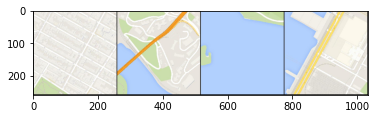

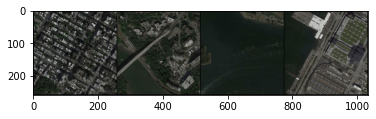

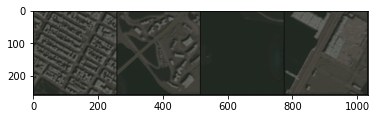

 55%|█████▍    | 150/274 [00:34<00:28,  4.30it/s]

Epoch 0: Step 150


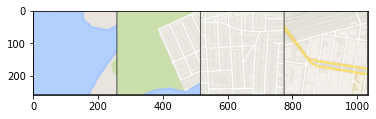

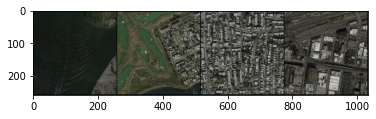

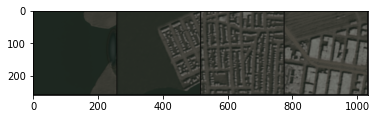

  9%|▉         | 26/274 [00:06<00:58,  4.24it/s]

Epoch 1: Step 300


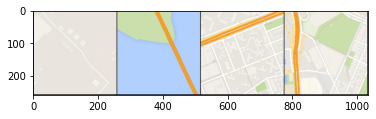

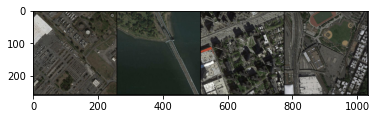

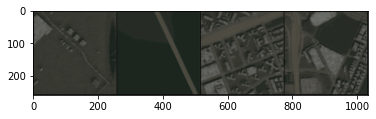

 64%|██████▍   | 176/274 [00:41<00:22,  4.32it/s]

Epoch 1: Step 450


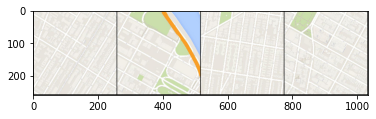

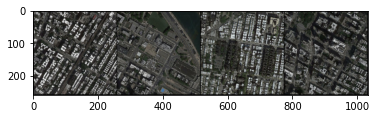

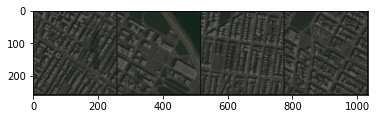

 19%|█▉        | 52/274 [00:12<00:51,  4.28it/s]

Epoch 2: Step 600


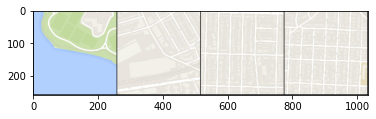

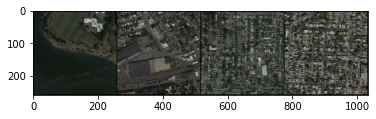

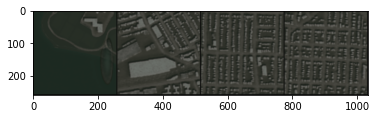

 74%|███████▎  | 202/274 [00:47<00:16,  4.30it/s]

Epoch 2: Step 750


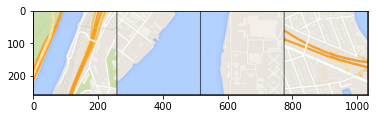

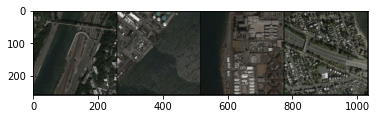

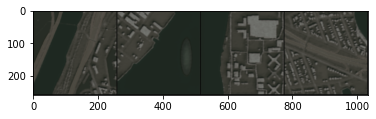

 28%|██▊       | 78/274 [00:18<00:45,  4.30it/s]

Epoch 3: Step 900


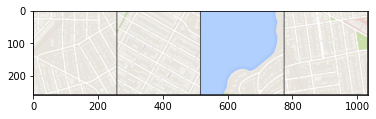

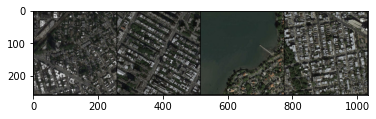

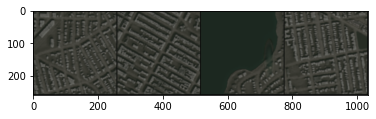

 83%|████████▎ | 228/274 [00:53<00:10,  4.33it/s]

Epoch 3: Step 1050


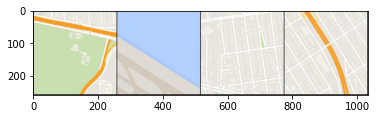

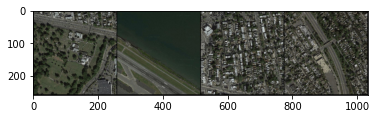

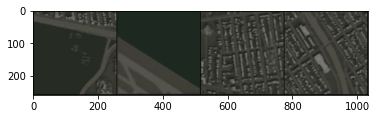

 38%|███▊      | 104/274 [00:24<00:40,  4.22it/s]

Epoch 4: Step 1200


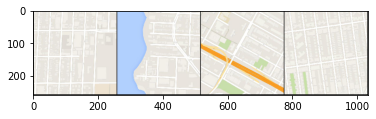

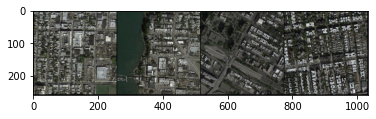

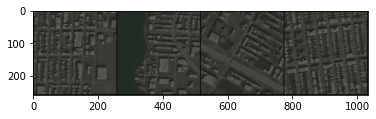

 93%|█████████▎| 254/274 [00:59<00:04,  4.26it/s]

Epoch 4: Step 1350


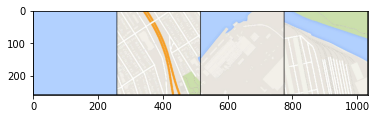

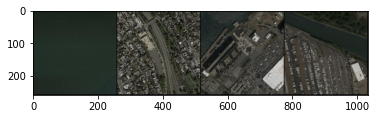

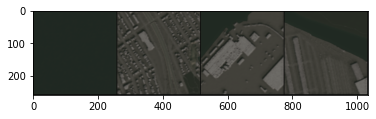

 47%|████▋     | 130/274 [00:30<00:33,  4.33it/s]

Epoch 5: Step 1500


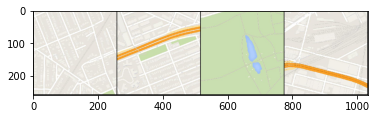

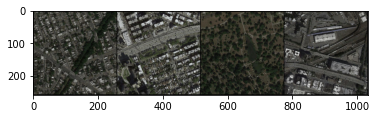

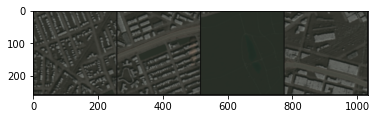

  2%|▏         | 6/274 [00:01<01:01,  4.33it/s]

Epoch 6: Step 1650


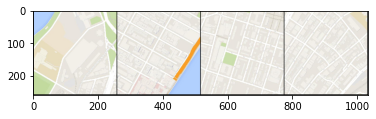

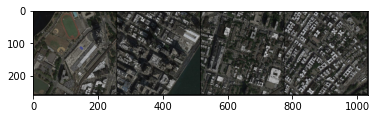

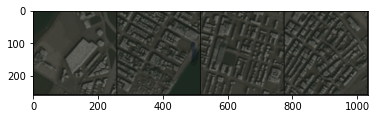

 57%|█████▋    | 156/274 [00:36<00:27,  4.34it/s]

Epoch 6: Step 1800


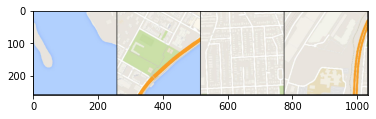

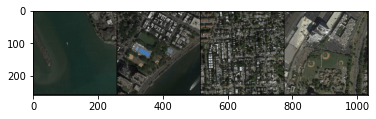

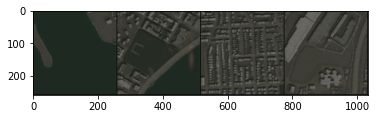

 12%|█▏        | 32/274 [00:07<00:55,  4.33it/s]

Epoch 7: Step 1950


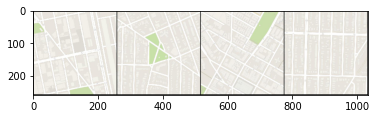

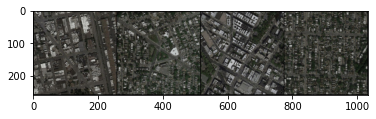

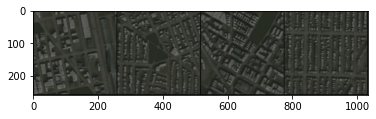

 66%|██████▋   | 182/274 [00:42<00:21,  4.35it/s]

Epoch 7: Step 2100


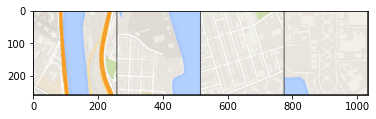

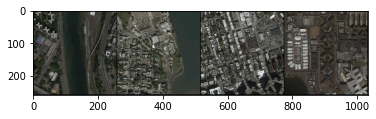

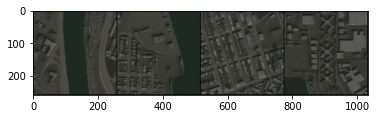

 21%|██        | 58/274 [00:13<00:49,  4.34it/s]

Epoch 8: Step 2250


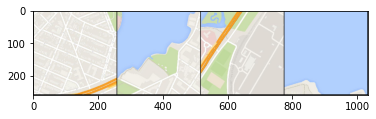

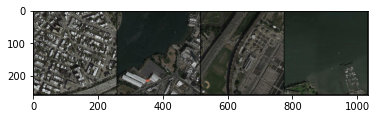

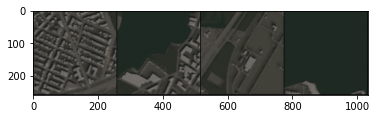

 76%|███████▌  | 208/274 [00:49<00:15,  4.34it/s]

Epoch 8: Step 2400


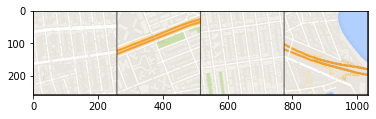

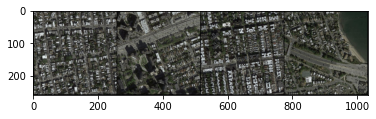

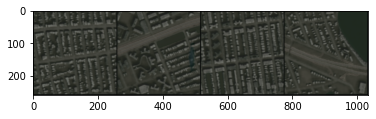

 31%|███       | 84/274 [00:19<00:44,  4.30it/s]

Epoch 9: Step 2550


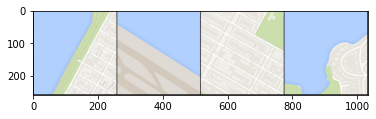

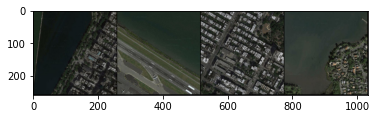

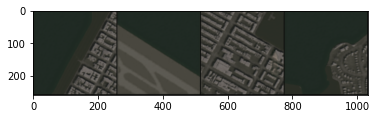

 85%|████████▌ | 234/274 [00:54<00:09,  4.28it/s]

Epoch 9: Step 2700


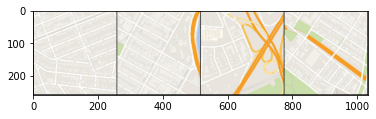

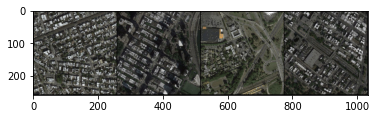

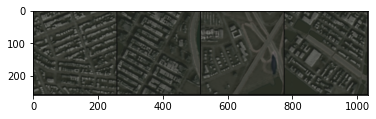

 40%|████      | 110/274 [00:25<00:38,  4.28it/s]

Epoch 10: Step 2850


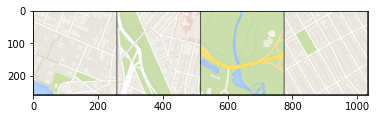

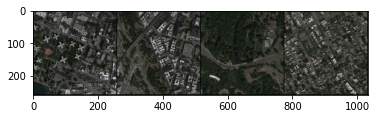

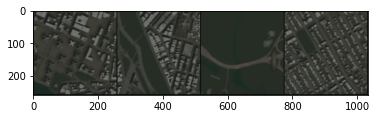

 95%|█████████▍| 260/274 [01:00<00:03,  4.33it/s]

Epoch 10: Step 3000


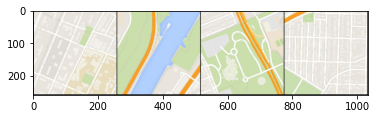

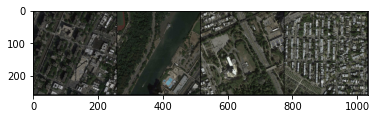

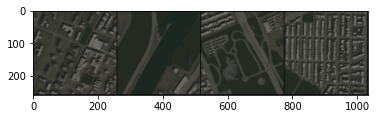

 50%|████▉     | 136/274 [00:31<00:31,  4.34it/s]

Epoch 11: Step 3150


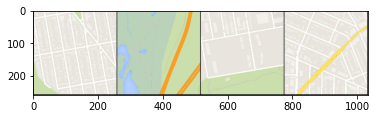

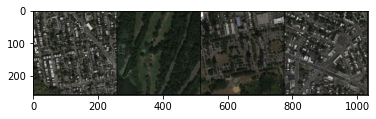

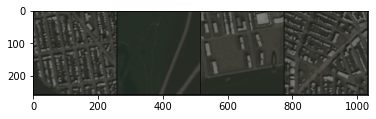

  4%|▍         | 12/274 [00:02<01:01,  4.25it/s]

Epoch 12: Step 3300


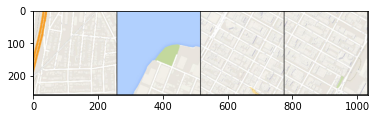

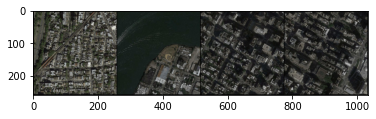

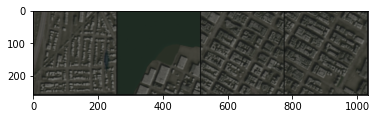

 59%|█████▉    | 162/274 [00:38<00:25,  4.32it/s]

Epoch 12: Step 3450


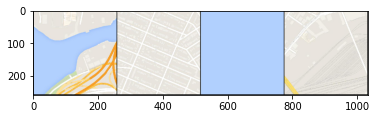

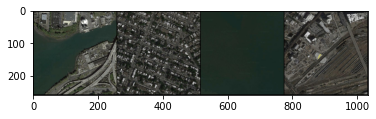

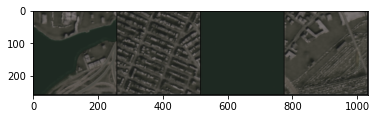

  6%|▌         | 17/274 [00:03<01:00,  4.26it/s]


KeyboardInterrupt: 

In [19]:
def train_model(gen, disc, disc_opt, gen_opt, n_epochs = 15, adv_criterion=nn.BCEWithLogitsLoss(), recon_loss_criterion = nn.L1Loss(), lambda_recon_loss=200, dim=3, display_every=150, batch_size=4, target_shape=256, device='cuda', save_model=False):
    """
    Trains the GAN for the n_epochs epochs. Generates fake images with no backpropagation, 
        backpropogates through disc, finally backpropgates through gen.
    :gen: The generator
    :disc: The discriminator
    :disc_opt: The discriminator optimizer
    :gen_opt: The generator optimizer
    :n_epochs: The number of epochs to train for
    :adv_criterion: Adversarial loss function
    :recon_loss_criterion: Reconstruction loss function
    :lamba_recon_loss: Lamba penalty for reconstruction loss
    :dim: Number of channels of input imgs
    :display_every: Number of steps to display training progress
    :batch_size: The batch size
    :target_size: lxw to reshape image into for quicker training
    :device: the device to train model on
    :save_model: Saves model every display_every steps if True
    """
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    
    cur_step = 0
    for epoch in range(n_epochs):
        for img in (tqdm(train_loader)):
            width = img.shape[3]
            inputs = img[:, :, :, width // 2:]
            inputs = nn.functional.interpolate(inputs, size=target_shape)
            real = img[:, :, :, :width // 2]
            real = nn.functional.interpolate(real, size=target_shape)
            inputs = inputs.to(device)
            real = real.to(device)
            
            #generate fakes
            with torch.no_grad():
                fake = gen(inputs)
            
            #update discriminator
            disc_opt.zero_grad()
            disc_loss = get_disc_loss(disc, fake.detach(), real, inputs, adv_criterion)
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
            
            #update generator
            gen_opt.zero_grad()
            gen_loss = get_gen_loss(gen, disc, real, inputs, adv_criterion, recon_loss_criterion, lambda_recon_loss)
            gen_loss.backward()
            gen_opt.step()
            
            #show every 
            if cur_step % display_every == 0:
                print(f"Epoch {epoch}: Step {cur_step}")
                show_tensor_images(inputs, size=(dim, target_shape, target_shape))
                show_tensor_images(real, size=(dim, target_shape, target_shape))
                show_tensor_images(fake, size=(dim, target_shape, target_shape))
                if save_model:
                        torch.save({'gen': gen.state_dict(),
                            'gen_opt': gen_opt.state_dict(),
                            'disc': disc.state_dict(),
                            'disc_opt': disc_opt.state_dict()
                        }, f"pix2pix_{cur_step}.pth")
            cur_step += 1

train_model(gen, disc, disc_opt, gen_opt)

In [20]:
#save models
torch.save(gen, 'gen_chk.pt')
torch.save(disc, 'disc_chk.pt')

## Inference on validation data

In [18]:
checkpoint = True #load models from checkpoint

In [19]:
if checkpoint:
    gen = torch.load('gen_chk.pt').to('cuda')

In [21]:
#load validation data
test_images = ImageData('val', transforms.ToTensor())
validation_loader = DataLoader(images, batch_size=1, shuffle=True)

In [22]:
def generate_random(image_iter, device='cuda'):
    """
    Randomly pull input from validation image set and generate image
    Displays: Input, Ground Truth, Prediction
    """
    img = next(image_iter)
    width = img.shape[3]
    target_shape=256
    inputs = img[:, :, :, width // 2:]
    inputs = nn.functional.interpolate(inputs, size=target_shape)
    real = img[:, :, :, :width // 2]
    real = nn.functional.interpolate(real, size=target_shape)
    inputs = inputs.to(device)
    real = real.to(device)
    
    #generate fake image
    with torch.no_grad():
        fake = gen(inputs)
        
    show_tensor_images(inputs, num_images=1)
    show_tensor_images(real, num_images=1)
    show_tensor_images(fake, num_images=1)

In [23]:
image_iter = iter(validation_loader)

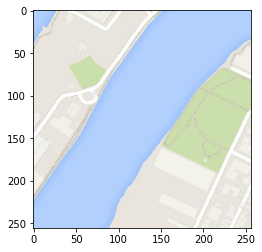

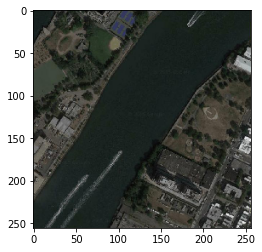

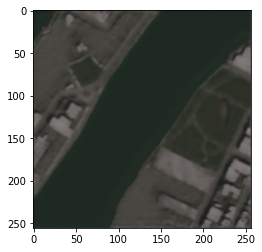

In [26]:
generate_random(image_iter)